# Automated Feature Engineering

Now I'll use a technique called Automated Feature Engineering. Typically, good features come from domain knowledge, where it is necessary to know about the field to devleop good features. This is an expensive process, with a lot of intuition and data manipulation. Needless to say that this process may be a little tedious.

In order to avoid that, I'll use the featuretools package. This package acts in two fronts: transformations and aggregations. In the transformation analysis, features are created from a single table (it is similar to the feature expansion performed above). On the other hand, feature aggregation utilizes information across many related tables, which can be a complex task depending on how many tables there are.

The method is based on Deep Feature Synthesis, which stacks many transformation and aggregation operations to create features from data spread across many tables.

In [35]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
os.getcwd()

'C:\\Users\\Hugo\\Desktop\\hugo\\DataScience\\Kaggle\\kaggle_credit_risk\\notebooks'

In [3]:
# Importing utils 
os.chdir('C:\\Users\\Hugo\\Desktop\\hugo\\DataScience\\Kaggle\\kaggle_credit_risk\\code')

from utils import *

# Data directory
os.chdir('C:\\Users\\Hugo\\Desktop\\hugo\\DataScience\\Kaggle\\kaggle_credit_risk\\data')

### Importing featuretools for automated feature engineering

In [4]:
import featuretools as ft

Disclaimer: I'll just use 1000 rows for each dataframe, because my current notebook cannot handle the total amount of data (hence, it is just for exploration, I'm not gonna use this results further in my analysis).

In [5]:
app_train = pd.read_csv('application_train.csv').sort_values('SK_ID_CURR').reset_index(drop = True).iloc[:1000,:]

app_test = pd.read_csv('application_test.csv').sort_values('SK_ID_CURR').reset_index(drop = True).iloc[:1000,:]

bureau = pd.read_csv('bureau.csv').sort_values(['SK_ID_CURR', 'SK_ID_BUREAU']).reset_index(drop = True).iloc[:1000,:]

bureau_balance = pd.read_csv('bureau_balance.csv').sort_values('SK_ID_BUREAU').reset_index(drop = True).iloc[:1000,:]

cash = pd.read_csv('POS_CASH_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).iloc[:1000,:]

credit = pd.read_csv('credit_card_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).iloc[:1000,:]

previous = pd.read_csv('previous_application.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).iloc[:1000,:]

installments = pd.read_csv('installments_payments.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).iloc[:1000,:]

It is important to identify which set we are dealing with, that's why it is necessary to add a set column in the datasets

In [8]:
# Add identifying column
app_train['set'] = 'train'
app_test['set'] = 'test'
app_test["TARGET"] = np.nan

# Append the dataframes
app = app_train.append(app_test, ignore_index = True)

C:\Users\Hugo\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


# Entities and EntitySet

An entity is basically a pandas dataframe. An entity must have an unique index column with no duplicated elements. We have app, bureau and previous dataframes which have just one unique index column. The other dataframes require to pass make_index = True parameter, specifying the name of the index.

An entityset is a collection of tables and the relationship between them. Using entitysets allows us to group together multiple tables and manipulate them quicker than individual tables.

In [9]:
# Entity set with id applications
es = ft.EntitySet(id = 'clients')

In [10]:
# Entities with a unique index
es = es.entity_from_dataframe(entity_id = 'app', dataframe = app, index = 'SK_ID_CURR')

es = es.entity_from_dataframe(entity_id = 'bureau', dataframe = bureau, index = 'SK_ID_BUREAU')

es = es.entity_from_dataframe(entity_id = 'previous', dataframe = previous, index = 'SK_ID_PREV')

# Entities that do not have a unique index
es = es.entity_from_dataframe(entity_id = 'bureau_balance', dataframe = bureau_balance, 
                              make_index = True, index = 'bureaubalance_index')

es = es.entity_from_dataframe(entity_id = 'cash', dataframe = cash, 
                              make_index = True, index = 'cash_index')

es = es.entity_from_dataframe(entity_id = 'installments', dataframe = installments,
                              make_index = True, index = 'installments_index')

es = es.entity_from_dataframe(entity_id = 'credit', dataframe = credit,
                              make_index = True, index = 'credit_index')

# Relationships

Relationships between tables and defined as which index are commom between them in order to join these tables. They can be defined as one-to-one, and one-to-many, where a register in table 1 is connected to table 2 by one or many other registers (this connection can be defined by the index column).

With this relationships, it is quite easy to join tables and aggregate multiple registers into one single enriched register.


In [11]:
# Relationship between app and bureau
r_app_bureau = ft.Relationship(es['app']['SK_ID_CURR'], es['bureau']['SK_ID_CURR'])

# Relationship between bureau and bureau balance
r_bureau_balance = ft.Relationship(es['bureau']['SK_ID_BUREAU'], es['bureau_balance']['SK_ID_BUREAU'])

# Relationship between current app and previous apps
r_app_previous = ft.Relationship(es['app']['SK_ID_CURR'], es['previous']['SK_ID_CURR'])

# Relationships between previous apps and cash, installments, and credit
r_previous_cash = ft.Relationship(es['previous']['SK_ID_PREV'], es['cash']['SK_ID_PREV'])
r_previous_installments = ft.Relationship(es['previous']['SK_ID_PREV'], es['installments']['SK_ID_PREV'])
r_previous_credit = ft.Relationship(es['previous']['SK_ID_PREV'], es['credit']['SK_ID_PREV'])

In [12]:
# Add in the defined relationships
es = es.add_relationships([r_app_bureau, r_bureau_balance, r_app_previous,
                           r_previous_cash, r_previous_installments, r_previous_credit])
# Print out the EntitySet
es

Entityset: clients
  Entities:
    app [Rows: 2000, Columns: 123]
    bureau [Rows: 1000, Columns: 17]
    previous [Rows: 1000, Columns: 37]
    bureau_balance [Rows: 1000, Columns: 4]
    cash [Rows: 1000, Columns: 9]
    installments [Rows: 1000, Columns: 9]
    credit [Rows: 1000, Columns: 24]
  Relationships:
    bureau.SK_ID_CURR -> app.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous.SK_ID_CURR -> app.SK_ID_CURR
    cash.SK_ID_PREV -> previous.SK_ID_PREV
    installments.SK_ID_PREV -> previous.SK_ID_PREV
    credit.SK_ID_PREV -> previous.SK_ID_PREV

# Feature Primitives

A feature primitive is an operation applied to a table or a set of tables to create features. It can be grouped into 2 types of primitives:

- Aggregation: function that groups together child datapoints for each parent and then calculates a statistic such as mean, max, min or std. An aggregation works across multiple tables using the relationship between them.

- Transformation: an operation applied to one or more columns in a single table. An example would be taking the absolute value of a column, or expanding polynomial features.

In [13]:
# List the primitives in a dataframe
primitives = ft.list_primitives()

pd.options.display.max_colwidth = 100

primitives[primitives['type'] == 'aggregation'].head(10)

,name,type,description
0,std,aggregation,"Computes the dispersion relative to the mean value, ignoring `NaN`."
1,count,aggregation,"Determines the total number of values, excluding `NaN`."
2,n_most_common,aggregation,Determines the `n` most common elements.
3,num_true,aggregation,Counts the number of `True` values.
4,mean,aggregation,Computes the average for a list of values.
5,avg_time_between,aggregation,Computes the average number of seconds between consecutive events.
6,time_since_first,aggregation,Calculates the time elapsed since the first datetime (in seconds).
7,max,aggregation,"Calculates the highest value, ignoring `NaN` values."
8,all,aggregation,Calculates if all values are 'True' in a list.
9,min,aggregation,"Calculates the smallest value, ignoring `NaN` values."


In [14]:
primitives[primitives['type'] == 'transform'].head(10)

,name,type,description
20,or,transform,Element-wise logical OR of two lists.
21,day,transform,Determines the day of the month from a datetime.
22,less_than_equal_to_scalar,transform,Determines if values are less than or equal to a given scalar.
23,greater_than,transform,Determines if values in one list are greater than another list.
24,cum_sum,transform,Calculates the cumulative sum.
25,year,transform,Determines the year value of a datetime.
26,absolute,transform,Computes the absolute value of a number.
27,subtract_numeric,transform,Element-wise subtraction of two lists.
28,hour,transform,Determines the hour value of a datetime.
29,isin,transform,Determines whether a value is present in a provided list.


# Deep Feature Synthesis

DFS is the process used by featuretools in order to create feature from its primitives. DFS stacks those primitives to form features with a depth equal to the number of primitives. For example, if we take the maximum value of a client's previous loans, we get MAX(previous.loan_amount), this is depth of 1. To create a feature with depth of 2, we can take the maximum value of a client's average payment per previous loans MAX(previous(MEAN(installments.payment))).

In [24]:
# Default primitives from featuretools
default_agg_primitives =  ["sum", "std", "max", "skew", "min", "mean", "count", "percent_true", "num_unique", "mode"]
default_trans_primitives =  ["day", "year", "month", "weekday", "haversine"]

# DFS with specified primitives
feature_names = ft.dfs(entityset = es, target_entity = 'app',
                       trans_primitives = default_trans_primitives,
                       agg_primitives = default_agg_primitives, 
                       max_depth = 2,
                       features_only = True) # to return only the feature names, not compute them

print('%d Total Features' % len(feature_names))

1697 Total Features


Cool! Let's compute all of it.

In [25]:
# DFS with default primitives
feature_matrix, feature_names = ft.dfs(entityset = es, target_entity = 'app',
                                       trans_primitives = default_trans_primitives,
                                       agg_primitives = default_agg_primitives, 
                                       max_depth = 2, 
                                       features_only=False, 
                                       verbose = True)

pd.options.display.max_columns = 1700
feature_matrix.head(10)

Built 1697 features
Elapsed: 00:35 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 10/10 chunks


AMT_ANNUITY  AMT_CREDIT  AMT_GOODS_PRICE  AMT_INCOME_TOTAL  \
SK_ID_CURR                                                               
100001          20560.5    568800.0         450000.0          135000.0   
100002          24700.5    406597.5         351000.0          202500.0   
100003          35698.5   1293502.5        1129500.0          270000.0   
100004           6750.0    135000.0         135000.0           67500.0   
100005          17370.0    222768.0         180000.0           99000.0   
100006          29686.5    312682.5         297000.0          135000.0   
100007          21865.5    513000.0         513000.0          121500.0   
100008          27517.5    490495.5         454500.0           99000.0   
100009          41301.0   1560726.0        1395000.0          171000.0   
100010          42075.0   1530000.0        1530000.0          360000.0   

            AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_HOUR  \
SK_ID_CURR                                                          
100001                            0.0                         0.0   
100002                            0.0                         0.0   
100003                            0.0                         0.0   
100004                            0.0                         0.0   
100005                            0.0                         0.0   
100006                            NaN                         NaN   
100007                            0.0                         0.0   
100008                            0.0                         0.0   
100009                            0.0                         0.0   
100010                            0.0                         0.0   

            AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
SK_ID_CURR                                                         
100001                            0.0                        0.0   
100002                            0.0                        0.0   
100003                            0.0                        0.0   
100004                            0.0                        0.0   
100005                            0.0                        0.0   
100006                            NaN                        NaN   
100007                            0.0                        0.0   
100008                            0.0                        1.0   
100009                            1.0                        1.0   
100010                            0.0                        0.0   

            AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_YEAR  \
SK_ID_CURR                                                           
100001                             0.0                         0.0   
100002                             0.0                         1.0   
100003                             0.0                         0.0   
100004                             0.0                         0.0   
100005                             0.0                         3.0   
100006                             NaN                         NaN   
100007                             0.0                         0.0   
100008                             0.0                         1.0   
100009                             0.0                         2.0   
100010                             0.0                         0.0   

            APARTMENTS_AVG  APARTMENTS_MEDI  APARTMENTS_MODE  \
SK_ID_CURR                                                     
100001              0.0660           0.0666           0.0672   
100002              0.0247           0.0250           0.0252   
100003              0.0959           0.0968           0.0924   
100004                 NaN              NaN              NaN   
100005                 NaN              NaN              NaN   
100006                 NaN              NaN              NaN   
100007                 NaN              NaN              NaN   
100008                 NaN              NaN              NaN

We've created a lot of features! This process was quite easy using featuretools. Unfortunatelly, my computer is only 8GB RAM, and because of that I can't try with the full dataframes to create ML models and submissions. But that's OK. I'll try some time soon.

# Correlations

By creating a lot of features, some of them might be highly correlated with the target but just because of simple noise. Another problem is the high correlation between features, which can dimish interpretability and generalization performance on the test set. Let's calculate some correlations.

In [27]:
correlations = feature_matrix.corr().sort_values('TARGET')['TARGET']

In [28]:
correlations.head()

MEAN(previous.NUM_UNIQUE(cash.NAME_CONTRACT_STATUS))   -0.449339
NUM_UNIQUE(cash.NAME_CONTRACT_STATUS)                  -0.396900
MAX(previous.NUM_UNIQUE(cash.NAME_CONTRACT_STATUS))    -0.396900
MAX(previous.STD(credit.AMT_PAYMENT_CURRENT))          -0.393851
MEAN(previous.STD(credit.AMT_PAYMENT_CURRENT))         -0.393851
Name: TARGET, dtype: float64

In [30]:
correlations.dropna().tail()

MEAN(previous.SKEW(installments.NUM_INSTALMENT_VERSION))    0.661536
MIN(previous.STD(installments.AMT_INSTALMENT))              0.683826
MIN(previous.MAX(installments.AMT_INSTALMENT))              0.698234
MIN(previous.SKEW(installments.NUM_INSTALMENT_VERSION))     0.712899
TARGET                                                      1.000000
Name: TARGET, dtype: float64

Several features created by featuretools and highly correlated with the target, but that doesn't necessarilly mean they are important. Let's make some plots to investigate it.

In [32]:
train_set = feature_matrix[feature_matrix['set'] == 'train']

In [36]:
def kde_target_plot(df, feature):
    """Kernel density estimate plot of a feature colored
    by value of the target."""
    
    # Need to reset index for loc to workBU
    df = df.reset_index()
    plt.figure(figsize = (10, 6))
    plt.style.use('fivethirtyeight')
    
    # plot repaid loans
    sns.kdeplot(df.loc[df['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df.loc[df['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of Feature by Target Value')
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    plt.show()

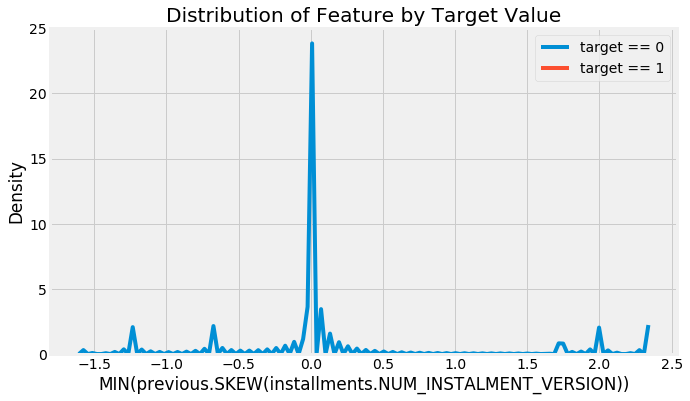

In [37]:
kde_target_plot(train_set, 'MIN(previous.SKEW(installments.NUM_INSTALMENT_VERSION))')

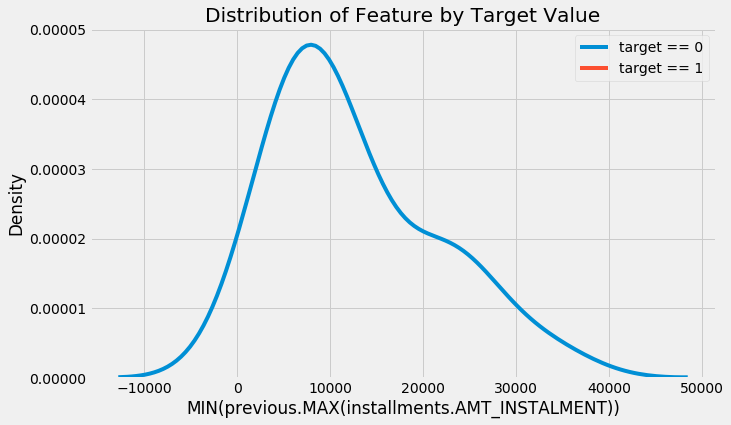

In [38]:
kde_target_plot(train_set, 'MIN(previous.MAX(installments.AMT_INSTALMENT))')

In [39]:
train_set.TARGET.value_counts()

0.0    930
1.0     70
Name: TARGET, dtype: int64

Since I have only 1000 rows, these results are not quite trustworthy. I'll make this analysis when I'll manage to expand the featuretools to more rows.

# Conclusion

Featuretools is a great tool to perform feature engineering in an automated fashion. It creates a lot of transformations and aggregations primitives, creating a whole new set of features.

A study on correlation is necessary in order to find high correlated features with the target and with each other.

If you liked this method, check out the [original paper](https://dai.lids.mit.edu/wp-content/uploads/2017/10/DSAA_DSM_2015.pdf) on Automated Feature Engineering.

Cheers.